In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [7]:
import datetime as dt
import yfinance as yf

start_date_str = input("Veuillez entrer la date de début au format YYYY-MM-DD : ")
start_date = dt.datetime.strptime(start_date_str, "%Y-%m-%d").date()
end_date = dt.date.today()

trading_days = 252

ticker = ['GLD','^SPX']

raw_data = yf.download(ticker, start_date, end_date)
df_time_series = raw_data['Adj Close']

df_time_series = df_time_series.dropna()

Veuillez entrer la date de début au format YYYY-MM-DD :  2019-07-24


[*********************100%***********************]  2 of 2 completed


In [8]:
df_price = df_time_series.reset_index(drop=True)
lst_date = df_time_series.index.tolist()

def compute_metrics(time_series, date):
    S0 = time_series.iloc[0]
    St = time_series.iloc[-1]
    first_date = date[0]
    last_date = date[-1]
    difference = last_date - first_date

    ann_return = (St/S0) ** (365.25/difference.days) - 1
            
    log_returns = np.log(time_series / time_series.shift(1)).dropna()
    ann_stdev = log_returns.std() * np.sqrt(252)
            
    sharpe = (ann_return) / ann_stdev

    drawdown = time_series / time_series.cummax() - 1
    max_dd = drawdown.min()
    recovery_MDD = drawdown.max()

    for column in drawdown:
        for i in range(len(drawdown)):
            if drawdown[column][i] == max_dd[column] and drawdown[column][i-1] != max_dd[column]:
                beg_date = drawdown.index[i]
                for j in range(i, len(drawdown)):
                    if drawdown[column][j] == 0:
                        end_date = drawdown.index[j]
                        recovery_MDD[column] = (end_date - beg_date).days 
                        break

    cum_return = St / S0 - 1

    oneY_prices = time_series.loc[time_series.index == last_date - dt.timedelta(365)]
    oneY_return = (St / oneY_prices) - 1
    oneY_return = oneY_return.reset_index(drop=True, inplace=False).transpose()

    threeY_prices = time_series.loc[time_series.index == last_date - dt.timedelta(365*3)]
    threeY_return = (St / threeY_prices) ** (365 / (365*3)) - 1
    threeY_return = threeY_return.reset_index(drop=True, inplace=False).transpose()

    fiveY_prices = time_series.loc[time_series.index == last_date - dt.timedelta(365*5)]
    fiveY_return = (St / fiveY_prices) ** (365 / (365*5)) - 1
    fiveY_return = fiveY_return.reset_index(drop=True, inplace=False).transpose()

    YTD_price = time_series.loc[time_series.index == dt.datetime.strptime("30-12-2022", "%d-%m-%Y")]
    YTD_return = (St / YTD_price) - 1
    YTD_return = YTD_return.reset_index(drop=True, inplace=False).transpose()

    Calmar = abs(ann_return / max_dd)

    ratio_set = pd.concat([round(ann_return*100,2), round(ann_stdev*100,2),round(sharpe,2),round(max_dd*100,2),round(cum_return*100,2),round(oneY_return*100,2),
                            round(threeY_return*100,2), round(fiveY_return*100,2), round(YTD_return*100, 2), round(Calmar*100, 2), round(recovery_MDD)], axis=1, 
                            keys=['Ann_Return %', 'Ann_StdDev %', 'Sharpe', 'Max DD %', 'Cum_Return %','1Y %','3Y %','5Y %','YTD %', 'Calmar %','MDD Recovery (cdr)'])

    ratio_set.columns =  ratio_set.columns.droplevel(level=1) 
    ratio_set = ratio_set.transpose()
    
    return ratio_set

metrics_table = compute_metrics(df_time_series, lst_date)

display(metrics_table)

,GLD,^SPX
Ann_Return %,10.62,12.97
Ann_StdDev %,15.29,21.33
Sharpe,0.69,0.61
Max DD %,-22.00,-33.92
Cum_Return %,65.65,83.99
1Y %,22.70,21.98
5Y %,10.78,13.09
YTD %,31.21,44.70
Calmar %,48.28,38.23
MDD Recovery (cdr),525.00,148.00


In [9]:
#Rebased
rebased = 100*(df_time_series / df_time_series.iloc[0, :])

#Traling metrics
trailing_return = (df_time_series / df_time_series.shift(trading_days)) - 1
log_returns = np.log(df_time_series / df_time_series.shift(1)).dropna()
trailing_vol = log_returns.rolling(window=trading_days).std() * np.sqrt(252)
trailing_sharpe = trailing_return / trailing_vol
drawdown = df_time_series / df_time_series.cummax() - 1
trailing_max_dd = drawdown.rolling(window=trading_days).min()

#Recovery vs DD
recovery = pd.DataFrame(drawdown)
 
for column in drawdown :
    for i in range(len(drawdown)):
        if drawdown[column][i] < 0:  
            beg_date = drawdown.index[i]
            for j in range(i, len(drawdown)):
                if drawdown[column][j] == 0:
                    end_date = drawdown.index[j]
                    recovery[column][i] = (end_date - beg_date).days/30
                    break
            else:
                recovery[column][i] = 0

drawdown = df_time_series / df_time_series.cummax()-1

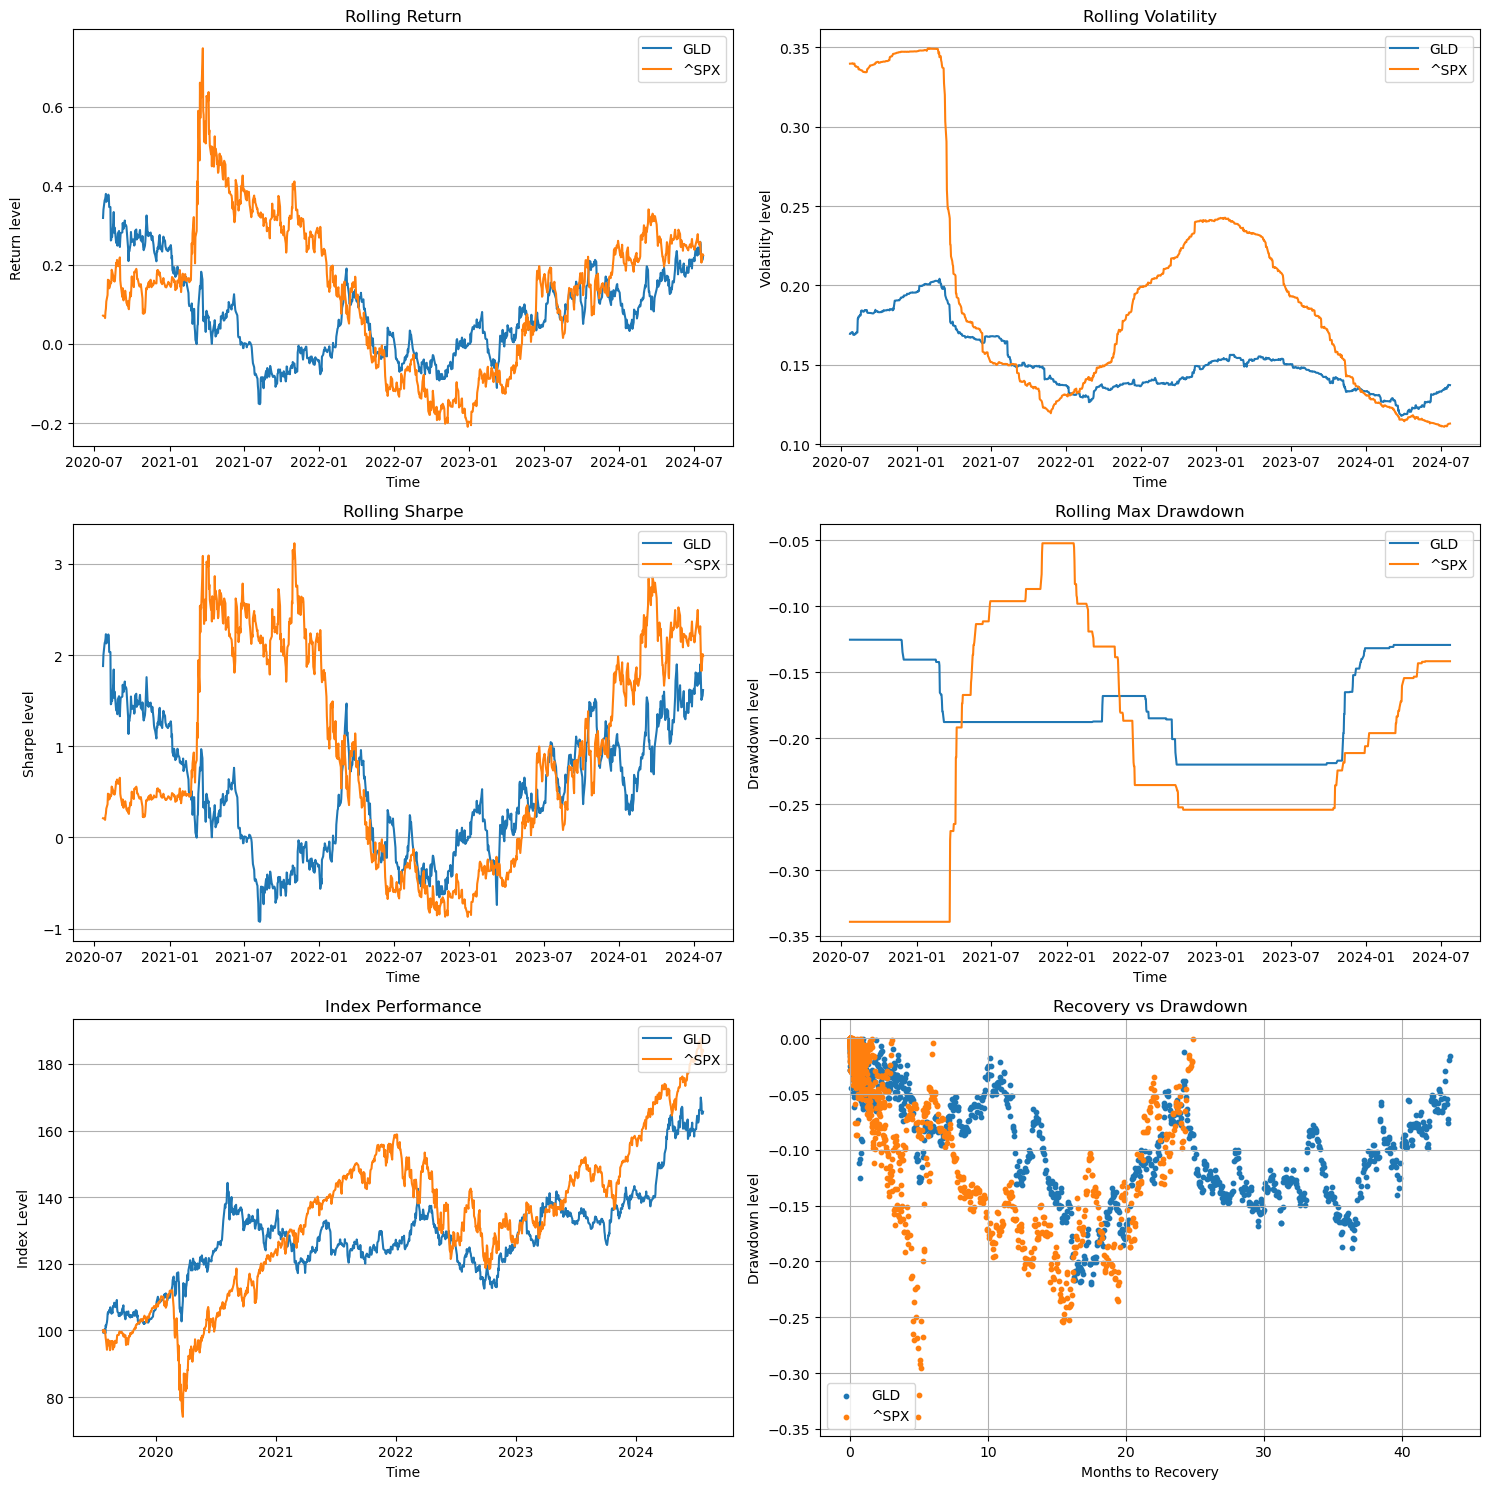

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plotting Rolling Return
axs[0, 0].plot(trailing_return)
axs[0, 0].set_title('Rolling Return')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Return level')
axs[0, 0].legend(ticker, loc='upper right')
axs[0, 0].grid(axis='y')

# Plotting Rolling Volatility
axs[0, 1].plot(trailing_vol)
axs[0, 1].set_title('Rolling Volatility')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Volatility level')
axs[0, 1].legend(ticker, loc='upper right')
axs[0, 1].grid(axis='y')

# Plotting Rolling Sharpe
axs[1, 0].plot(trailing_sharpe)
axs[1, 0].set_title('Rolling Sharpe')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Sharpe level')
axs[1, 0].legend(ticker, loc='upper right')
axs[1, 0].grid(axis='y')

# Plotting Rolling Max Drawdown
axs[1, 1].plot(trailing_max_dd)
axs[1, 1].set_title('Rolling Max Drawdown')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Drawdown level')
axs[1, 1].legend(ticker, loc='upper right')
axs[1, 1].grid(axis='y')

# Plotting Index Performance
axs[2, 0].plot(rebased)
axs[2, 0].set_title('Index Performance')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Index Level')
axs[2, 0].legend(ticker, loc='upper right')
axs[2, 0].grid(axis='y')

# Plotting Recovery
axs[2, 1].scatter(recovery[ticker[0]], drawdown[ticker[0]], label=ticker[0], s=10)
axs[2, 1].scatter(recovery[ticker[1]], drawdown[ticker[1]], label=ticker[1], s=10)
axs[2, 1].set_title('Recovery vs Drawdown')
axs[2, 1].set_xlabel('Months to Recovery')
axs[2, 1].set_ylabel('Drawdown level')
axs[2, 1].legend(loc='best', fontsize=10)
axs[2, 1].grid()

plt.tight_layout()
plt.show()